In [1]:
from osgeo import gdal #biblioteca para abrir as imagens - tem que selecinar o raster e passar para array - '3.8.5'
import rasterio #biblioteca para abrir a imagem - já abre como raster - '1.3.10'
from rasterio.enums import Resampling #Importando a função de reamostragem
import os #biblioteca para gerenciar os arquivos
import numpy as np #biblioteca para o cálculo das porcentagens - '1.26.4'
import pandas as pd #biblioteca para visualização dos dados em tabelas - '2.2.2'
import geopandas as gpd #biblioteca para visualização dos dados em tabelas - '0.14.4'
import matplotlib.pyplot as plt #biblioteca para o plot das imagens
import arosics as ars #biblioteca para efetuar o co-registro - '1.11.0'
from dbfread import DBF #biblioteca para leitura de tabelas no formato dbf
from tabulate import tabulate #biblioteca para foramatação das tabelas - '0.9.0'
import re #biblioteca para ordenar alfanumericamente - '2.2.1'
from skimage import exposure #Exposição e equalização de imagens
import shutil #biblioteca para mudar o diretório das imagens

os.chdir(r'C:\Users\Usuario\Documents\projeto_programacao\serie-temporal-wfi-L4\Reamostradas')

In [3]:
#lista dos arquivos das imagens da série - pode ser feito como input para utilização com outras séries
caminho = r'C:\Users\Usuario\Documents\projeto_programacao\serie-temporal-wfi-L4' #série temporal
caminho_reams = r'C:\Users\Usuario\Documents\projeto_programacao\serie-temporal-wfi-L4\Reamostradas' #serie temporal com as imagens reamostradas
caminho_rgbnir = r'C:/Users/Usuario/Documents/projeto_programacao/Registro_final' #registros RGBNir

#leitura de todos os arquivos da série
file_names = [filename for filename in os.listdir(caminho)]

##pegando satélite e data de aquisição - referência comparativas para os testes
#Variáveis de controle
satelite = []
data = []

#percorre os arquivos por nome, separa a cada "_" e retorna a data e o satélite.
for nome in file_names:
    if nome.endswith('.tif'):
     
        separacao = nome.split('_')
        
        satelite_nome = separacao[0]+separacao[1]
        satelite.append(satelite_nome)
        data.append(separacao[3])

#criando uma série com o nome do satélite e a data da imagem
dados = {'satélite': satelite,
         'data': data
        }

df_sat_date = pd.DataFrame(data=dados)

#print(df_sat_date)

In [4]:
# Abrir o arquivo raster original
for file in file_names:
    if file.endswith('tif'):
        with rasterio.open(f'{caminho}/{file}') as dataset:

            if 'CBERS_4A' in file:
                # Ler a imagem original
                original_image = dataset.read()
            
                # Redimensionar a imagem para nova resolução
                new_height = int(dataset.height * 55 / 64) #Redimensionando a altura
                new_width = int(dataset.width * 55 / 64) #Redimensionando a Largura
            
                # Reamostrar a imagem
                reamostrada_image = dataset.read(
                    out_shape=(dataset.count, new_height, new_width), #Parâmetros de altura e Largura
                    resampling=Resampling.nearest #Reamostrando para vizinho mais próximo
                )
            
                # Atualizar a resolução espacial nos metadados
                transform = dataset.transform * dataset.transform.scale(
                    (dataset.width / new_width),
                    (dataset.height / new_height)
                )
            
                profile = dataset.profile
                profile.update(transform=transform, width=new_width, height=new_height)

              
                # Salvar a imagem reamostrada em um novo arquivo
                with rasterio.open(f'{file}', 'w', **profile) as dist:
                    dist.write(reamostrada_image)
            else:
                shutil.copy2(f'{caminho}/{file}', caminho_reams)

#Releitura dos arquivos no novo caminho de todos os arquivos da série
file_names = [filename for filename in os.listdir(caminho_reams)]

Imagem com menor porcentagem de nuvens: C:\Users\Usuario\Documents\projeto_programacao\serie-temporal-wfi-L4\Reamostradas/AMAZONIA_1_WFI_20240107_033_017_L4.tif
Porcentagem de nuvens na imagem escolhida: 0.0028465467321643514 %


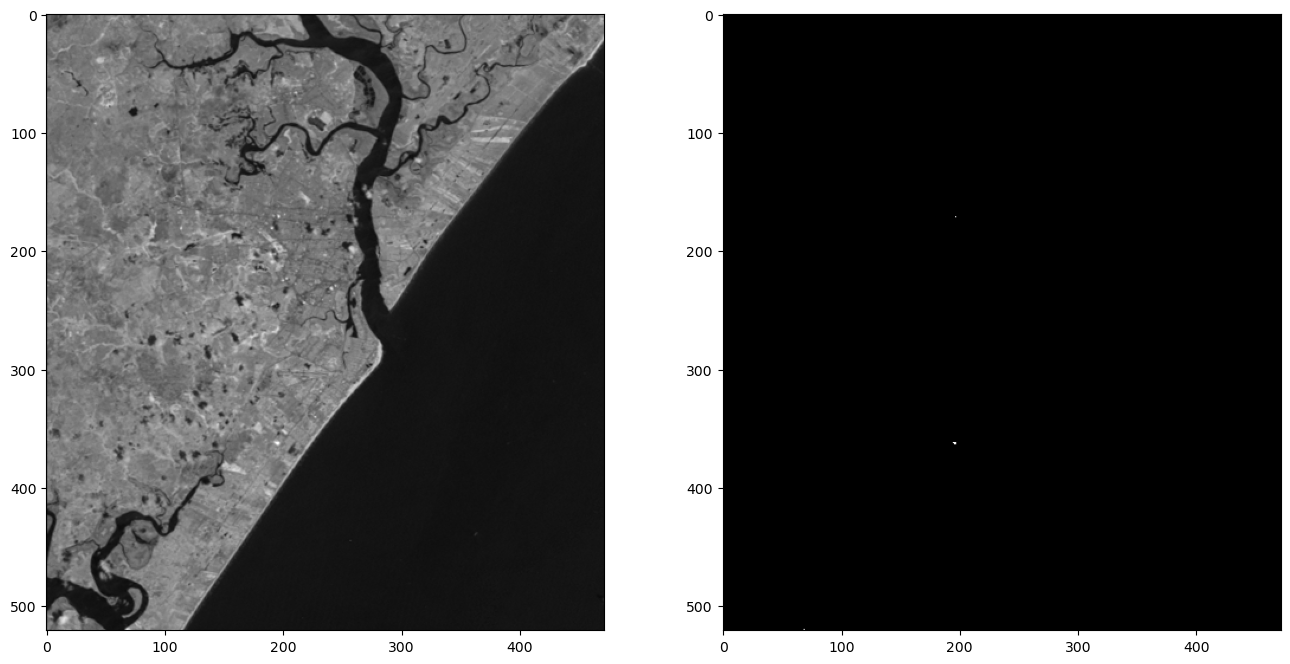

In [5]:
#Cálculo de nuvens
##variáveis de controle:
menor_porcentagem = 100
maior_porcentagem = 0
maximo = 0
menor_max = 16384 #para até 14 bits
imagem_menor_porcentagem = None
imagem_nuvens_menor_porcentagem = None
ref = None
names = []

#definindo a imagem com o menor máximo
for arquivo in file_names:
    
     #imagens reamostrdas foram geradas com 'tif_'.
     if arquivo.endswith('.tif'):
        caminho_imagem = f'{caminho_reams}/{arquivo}'

        #criação do vetor com os nomes e caminhos das imagens
        names.append(caminho_imagem)
         
        dataset = gdal.Open(caminho_imagem, gdal.GA_ReadOnly)
        banda_nir = dataset.GetRasterBand(4) #banda do ir
        
        ref = banda_nir.ReadAsArray()
        if maximo < menor_max:

            menor_max = ref.max()

        
        #porcentagem de nuvens para cada imagem da série - menor porcentagem
        porcentagem = (np.sum(ref > (menor_max*0.9)) / ref.size) * 100
        #print(f"Porcentagem de nuvens em {arquivo}: {porcentagem:.2f}%")

        #porcentagem de nuvens para cada imagem da série - maior porcentagem
        #porcentagem = (np.sum(ref > (menor_max*0.9)) / ref.size)*100

         
        #a porcentagem atual é menor que a menor porcentagem registrada até agora?
        if porcentagem < menor_porcentagem:
            
            menor_porcentagem = porcentagem
            imagem_menor_porcentagem = caminho_imagem

            #imagem das nuvens
            mascara_nuvens = (ref > (menor_max*0.9)).astype(np.uint8)

            imagem_nuvens_menor_porcentagem = ref * mascara_nuvens
            nir_ref =  ref #imagem selecionada
            name_ref = caminho_imagem #caminho da imagem selecionada



#colocando a imagem referência sempre na primeira posição do vetor names
names = [name_ref] + [nm for nm in names if nm != name_ref]

##imagem com menor porcentagem de nuvens
print("Imagem com menor porcentagem de nuvens:", imagem_menor_porcentagem)
print("Porcentagem de nuvens na imagem escolhida:", menor_porcentagem, "%")

##plot
plt.figure(figsize=(16, 8))

# #imagem original
plt.subplot(121)
plt.imshow(nir_ref, cmap="gray")


# #imagem das nuvens
plt.subplot(122)
plt.imshow(imagem_nuvens_menor_porcentagem, cmap="gray")

#salvando a imagem em um arquivo
plt.savefig('nuvem.png')




In [14]:
#Rodando para todas as bandas

#Variáveis de controle
img_trg_bandas = []
img_core = None

#a referência estará sempre no primeiro índice do names
img_ref = rasterio.open(names[0])

for i in range(1,len(names)):       

    #abre a imagem alvo i 
    img_trg = rasterio.open(names[i])

    #bandas de 1 a 4
    for j in range(1,5):
       
        #abrindo banda a banda da imagem referência e da imagem de alvo
        band_ref = img_ref.read(j);
                
        img_trg_bandas = img_trg.read(j)

        #definindo o nome de saída da imagem registrada
        registro_nome = f'registrada{i}_{j}_nrbg.tif'

        #auxílio para acompanhar o decorrer do código
        print(i,j,'\n')
    
        # Realiza o registro de imagens usando a lib AROSICS (argumentos)
        kwargs2 = {
        'grid_res': 10, #resolução do grid - 10 pixels
        'window_size': (20, 20), #janela de correspondendica de 20x20
        'path_out': registro_nome,
        'projectDir': f"{caminho_rgbnir}", 
        'min_reliability': 0, #pega pixels com o mínimo de 40% de confiabilidade
        'align_grids': True #grids alinhados - ref com alvo
        }

        #print(img_trg_bandas[j])
        
        tabela_nome = f'tabela{i}_{j}.tif'
        path_out= f"{caminho}\Tabelas\{tabela_nome}.shp"
        
        img_core = ars.COREG_LOCAL(band_ref, img_trg_bandas, **kwargs2)# Processa o registro por banda
        img_core.correct_shifts() #aplica a correção do deslocamento
        img_core.CoRegPoints_table #cria a tabela de deslocamentos
        img_core.tiepoint_grid.to_PointShapefile(path_out=path_out) #exporta um shapefilhe com todas as informações de deslocamento




1 1 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


<string>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\T'
<string>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\{'
<>:42: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14144\2390535854.py:42: SyntaxWarning: invalid escape sequence '\{'
  path_out= f"{caminho}\Tabelas\{tabela_nome}.shp"
C:\Users\Usuario\AppData\Local\Temp\ipykernel_14144\2390535854.py:42: SyntaxWarning: invalid escape sequence '\T'
  path_out= f"{caminho}\Tabelas\{tabela_nome}.shp"
	progress: |==================================================| 100.0% Complete  => 0:00:15
Translating progress |==================================================| 100.0% Complete  => 0:00:00


Found 1370 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
700 tie points flagged by level 2 filtering (SSIM).
26 tie points flagged by level 3 filtering (RANSAC)
644 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada1_1_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela1_1.tif.shp ...


	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

1 2 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:09
Translating progress |--------------------------------------------------| 0.0% Complete  => 0:00:00

Found 1199 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
489 tie points flagged by level 2 filtering (SSIM).
22 tie points flagged by level 3 filtering (RANSAC)
688 valid tie points remain after filtering.
Correcting geometric shifts...


Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada4_2_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela4_2.tif.shp ...


	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

4 3 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |=========-----------------------------------------| 17.6% Complete  => 0:00:01IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

	progress: |==================================================| 100.0% Complete  => 0:00:08
Translating progress |==================================================| 100.0% Complete  => 0:00:00
Warping progress     |==------------------------------------------------| 4.0% Complete  => 0:00:00

Found 526 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
179 tie points flagged by level 2 filtering (SSIM).
0 tie points flagged by level 3 filtering (RANSAC)
347 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:00
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (522, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada10_1_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela10_1.tif.shp ...


	progress: |--------------------------------------------------| 0.1% Complete  => 0:00:00

10 2 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -522.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |===================================---------------| 70.7% Complete  => 0:00:06IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

	progress: |==========================------------------------| 51.9% Complete  => 0:00:04IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

	progress: |==================================================| 100.0% Complete  => 0:00:09
Translating progress |==================================================| 100.0% Complete  =

Found 583 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
230 tie points flagged by level 2 filtering (SSIM).
5 tie points flagged by level 3 filtering (RANSAC)
348 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (522, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada13_3_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela13_3.tif.shp ...


	progress: |--------------------------------------------------| 0.2% Complete  => 0:00:00

13 4 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -522.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |===-----------------------------------------------| 6.3% Complete  => 0:00:01IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Translating progress |==================================================| 100.0% Complete  => 0:00:00


Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada15_3_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela15_3.tif.shp ...


	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

15 4 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:10


Found 1236 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
413 tie points flagged by level 2 filtering (SSIM).
26 tie points flagged by level 3 filtering (RANSAC)


Translating progress |==================================================| 100.0% Complete  => 0:00:00


797 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada15_4_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela15_4.tif.shp ...


	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

16 1 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |==================================================| 100.0% Complete  => 0:00:10


Found 1564 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
272 tie points flagged by level 2 filtering (SSIM).


Translating progress |==================================================| 100.0% Complete  => 0:00:00


88 tie points flagged by level 3 filtering (RANSAC)
1204 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:03
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada17_4_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela17_4.tif.shp ...


	progress: |--------------------------------------------------| 0.3% Complete  => 0:00:00

18 1 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -522.0, 473.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |==================--------------------------------| 36.1% Complete  => 0:00:03IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

	progress: |==================================================| 100.0% Complete  => 0:00:09


Found 926 matches.
Performing validity checks...
0 tie points flagged by level 1 filtering (reliability).
386 tie points flagged by level 2 filtering (SSIM).


Translating progress |==================================================| 100.0% Complete  => 0:00:00


12 tie points flagged by level 3 filtering (RANSAC)
528 valid tie points remain after filtering.
Correcting geometric shifts...


Warping progress     |==================================================| 100.0% Complete  => 0:00:01
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:830: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(False, 0).copy()  # replace booleans where column dtype is not bool but np.object
C:\Users\Usuario\.conda\envs\arosics\Lib\site-packages\arosics\Tie_Point_Grid.py:831: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  GDF2pass = GDF2pass.replace(True, 1).copy()
C:\Users\Usuario

Writing GeoArray of size (521, 472) to C:\Users\Usuario\Documents\projeto_programação\Registro_final\registrada22_3_nrbg.tif.
Writing C:\Users\Usuario\Documents\projeto_programação\serie-temporal-wfi-L4\Tabelas\tabela22_3.tif.shp ...


	progress: |--------------------------------------------------| 0.4% Complete  => 0:00:00

22 4 

Calculating footprint polygon and actual data corner coordinates for reference image...
Bounding box of calculated footprint for reference image:
	(0.0, -521.0, 472.0, 0.0)
Calculating footprint polygon and actual data corner coordinates for image to be shifted...
Bounding box of calculated footprint for image to be shifted:
	(0.0, -521.0, 472.0, 0.0)
Matching window position (X,Y): 236.0/-260.5
Initializing tie points grid...
Calculating tie point grid (2544 points) using 8 CPU cores...


	progress: |===========================================-------| 86.5% Complete  => 0:00:08IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Digite o número da imagem(1 a 23) para abrir o comparativo:  10
Digite o número da banda(1 a 4):  4


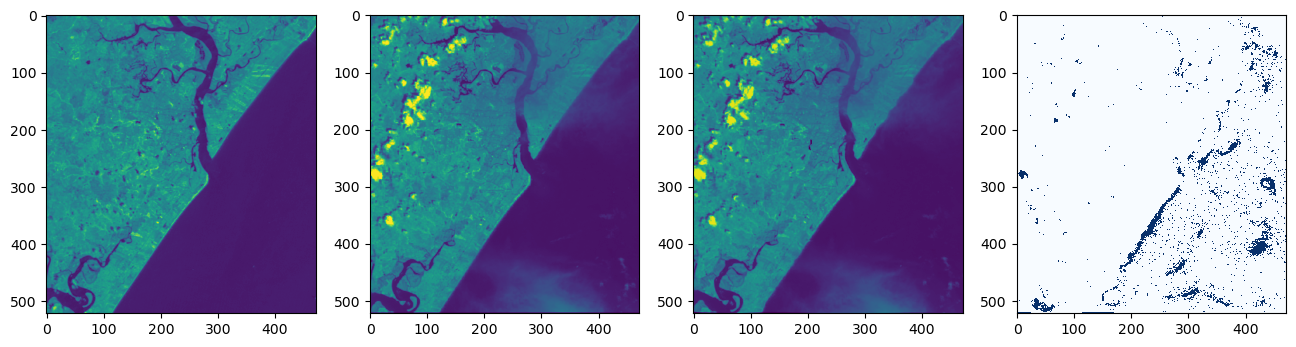

In [20]:
#avaliação comparativa das imagens antes e depois do co-registro

num_imagem = int(input('Digite o número da imagem(1 a 23) para abrir o comparativo: '))
num_banda = int(input('Digite o número da banda(1 a 4): '))

#abre a imagem registrada pelo número e banda selecionada
registro = gdal.Open(f'{caminho_rgbnir}/registrada{num_imagem}_{num_banda}_nrbg.tif').ReadAsArray()

trg_comp_img = gdal.Open(names[num_imagem])
trg_comp_img = trg_comp_img.GetRasterBand(num_banda).ReadAsArray()

tgt_diferenca = (trg_comp_img == registro)


plt.figure(figsize = (16,8))
plt.subplot(141)
plt.imshow(nir_ref)
plt.subplot(142)
plt.imshow(trg_comp_img)
plt.subplot(143)
plt.imshow(registro)
plt.subplot(144)
plt.imshow(tgt_diferenca, cmap=plt.get_cmap('Blues',2))
plt.savefig('maiorDes.png')



Entre com qual banda deseja analisar os resultados (1 a 4):  4


Valores mínimo, máximo e médio de deslocamento por tabela:
                      Mínimo    Máximo     Médio
tabela1_4.tif.dbf   0.036504  6.428962  0.337993
tabela2_4.tif.dbf   0.034067  5.362788  0.507149
tabela3_4.tif.dbf   0.039957  5.951625  0.580617
tabela4_4.tif.dbf   0.025456  6.594820  0.554505
tabela5_4.tif.dbf   0.014149  6.770734  0.397714
tabela6_4.tif.dbf   0.069175  5.090809  0.874172
tabela7_4.tif.dbf   0.061856  6.605562  0.846679
tabela8_4.tif.dbf   0.106487  6.391263  1.314652
tabela9_4.tif.dbf   0.065111  6.367634  1.204756
tabela10_4.tif.dbf  0.067782  6.513654  1.543989
tabela11_4.tif.dbf  0.090021  6.123428  0.718104
tabela12_4.tif.dbf  0.124709  6.144277  1.063783
tabela13_4.tif.dbf  0.102231  6.472345  1.157550
tabela14_4.tif.dbf  0.094645  6.968594  1.374799
tabela15_4.tif.dbf  0.089391  6.573901  0.621487
tabela16_4.tif.dbf  0.039884  6.693715  0.546572
tabela17_4.tif.dbf  0.022727  5.427015  0.491097
tabela18_4.tif.dbf  0.050770  6.338224  1.382896
tabela19_4

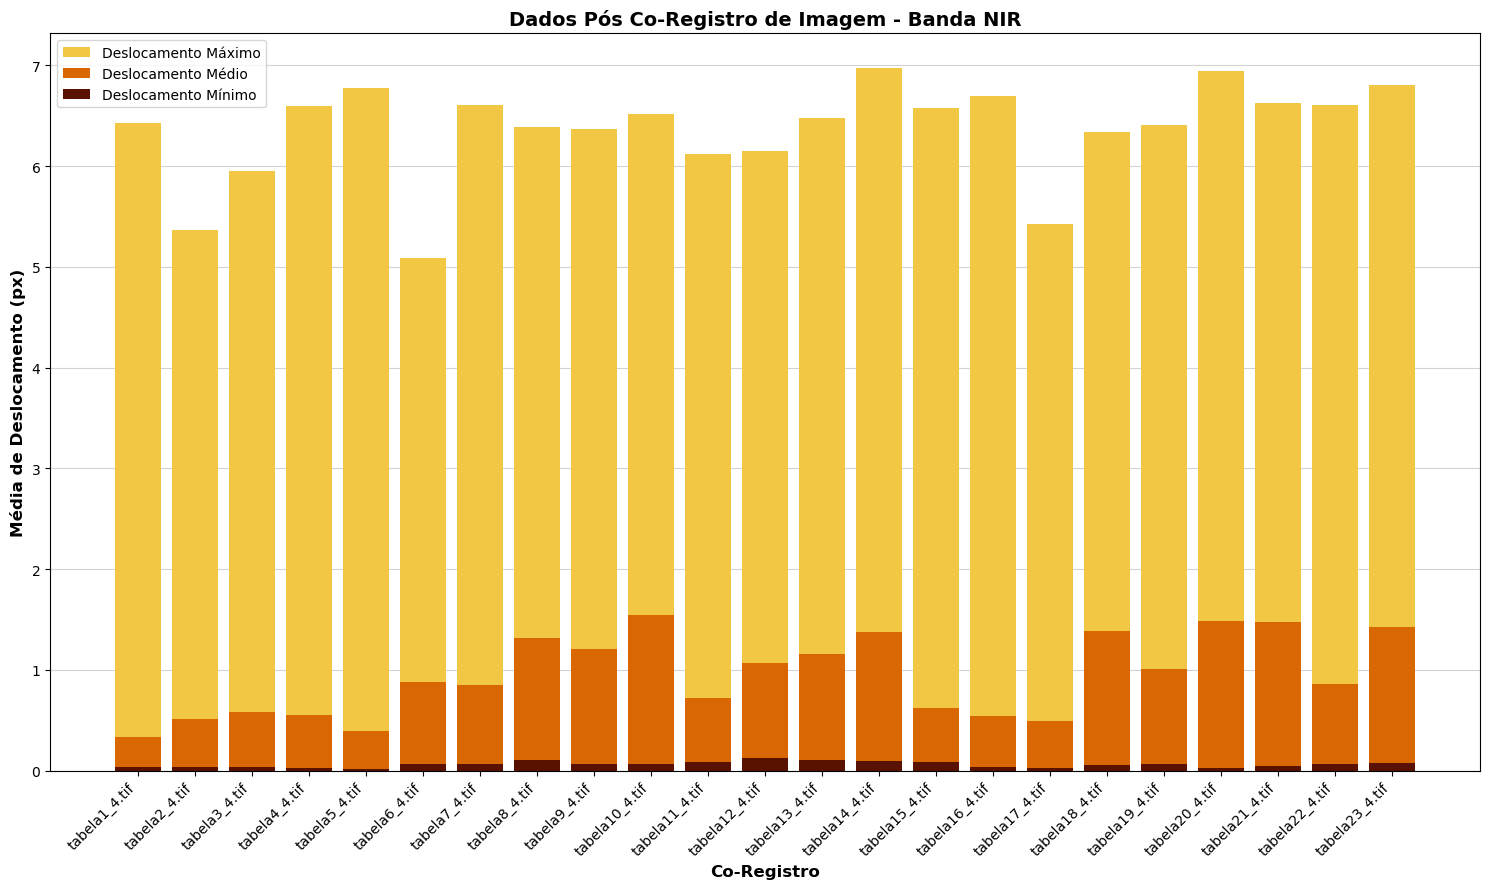

In [21]:
banda = input('Entre com qual banda deseja analisar os resultados (1 a 4): ')

#Leitura dos arquivos de tabela
file_names_tabelas = [filename for filename in os.listdir(f'{caminho}/Tabelas')]

#Função para ordenar em ordem alfanumérica
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

#ordenando as tabelas
file_names_tabelas = sorted_alphanumeric(file_names_tabelas)

#Função para ler as tabelas
def ler_tabelas_em_pasta(pasta):
    
    # Dicionário para armazenar os valores mínimo, máximo e médio de deslocamento de cada tabela
    valores_deslocamento = {}

    # Loop pelos arquivos na pasta
    for arquivo in file_names_tabelas:
        # Verifica se é um arquivo DBF
        
        if arquivo.endswith('.dbf') and f'_{banda}' in arquivo:
                
            # Caminho completo do arquivo
            caminho_arquivo = os.path.join(pasta, arquivo)
           
            # Lê o arquivo DBF como um DataFrame
            tabela = DBF(caminho_arquivo)
            df = pd.DataFrame(iter(tabela))          

            # Calcula os valores mínimo, máximo e médio de deslocamento (coluna 'ABS_SHIFT')
            valor_min = df['ABS_SHIFT'].min()
            valor_max = df['ABS_SHIFT'].max()
            valor_medio = df['ABS_SHIFT'].mean()

            # Adiciona os valores ao dicionário, usando o nome do arquivo como chave
            
            valores_deslocamento[arquivo] = {'min': valor_min, 'max': valor_max, 'medio': valor_medio}

    # Ordena as tabelas em ordem alfabética
   
    return valores_deslocamento

# Função para imprimir tabela tabulada
def imprimir_tabela_tabulada(valores_deslocamento):
    # Converter o dicionário para DataFrame
    df_valores_deslocamento = pd.DataFrame(valores_deslocamento).T

    # Renomear as colunas
    df_valores_deslocamento.columns = ['Mínimo', 'Máximo', 'Médio']

    # Imprimir a tabela
    print("Valores mínimo, máximo e médio de deslocamento por tabela:")
    print(df_valores_deslocamento.to_string())

# Pasta onde estão as tabelas (substitua pelo caminho da sua pasta)
pasta_das_tabelas = f'{caminho}/Tabelas'

# Chamada da função para ler as tabelas e calcular os valores mínimo, máximo e médio de deslocamento
valores_deslocamento = ler_tabelas_em_pasta(pasta_das_tabelas)

# Exibição dos valores mínimo, máximo e médio e plotagem do gráfico
if valores_deslocamento:
    # Imprimir tabela tabulada
    imprimir_tabela_tabulada(valores_deslocamento)

    # Prepara os dados para plotagem do gráfico
    tabelas = list(valores_deslocamento.keys())
    valores_min = [valores['min'] for valores in valores_deslocamento.values()]
    valores_max = [valores['max'] for valores in valores_deslocamento.values()]
    valores_medio = [valores['medio'] for valores in valores_deslocamento.values()]
    x = range(len(tabelas))

    # Plotagem do gráfico
    plt.figure(figsize=(15, 9))
   
    plt.bar(x, valores_max, color='#F2C744', alpha=1, label='Deslocamento Máximo')
    plt.bar(x, valores_medio, color='#D96704', alpha=1, label='Deslocamento Médio')
    plt.bar(x, valores_min, color='#591202', alpha=1, label='Deslocamento Mínimo')
    plt.xlabel('Co-Registro', fontsize=12, fontweight='bold')
    plt.ylabel('Média de Deslocamento (px)',fontsize=12, fontweight='bold')
    plt.title('Dados Pós Co-Registro de Imagem - Banda NIR',fontsize=14, fontweight='bold')
    plt.xticks(x, [tabela[:-4] for tabela in tabelas], rotation=45, ha='right')
    plt.legend()
    plt.grid(True, which='both', axis='y', color="lightgray")  # Configurar o grid
    plt.gca().set_axisbelow(True)  # Colocar o grid atrás do gráfico
    plt.tight_layout()
   # plt.show()
    plt.savefig('grafico.png',dpi=300)
else:
    print("Não foram encontradas tabelas na pasta especificada.")
